This is Luke's take on the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition.

Some interesting Kernels:
* [Laurenstc's kernel](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe)
* [Aleksandrs Gehsbargs's kernel](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force)
* [Serigne's kernel](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [Massquantity's kernel](https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4)
* [Fkstepz's kernel](https://www.kaggle.com/fkstepz/step-by-step-house-prices-prediction)

# 1. Prep
Import all libraries, define functions, and load data.

**Import all libraries and define functions**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders
import lightgbm as lgb
import missingno
import seaborn as sns
import sklearn.metrics
import sklearn.pipeline
import sklearn.impute
from sklearn.neighbors import LocalOutlierFactor
import tqdm
import warnings

# Turn off the nagging warnings from sklearn and seaborn
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Set plotting theme
sns.set_style('darkgrid')

**Load the data**

In [2]:
# Read core training and test data

# there isn't much to configure for the import,
# but when there is, it's nice to put this info into
# a dictionary or even dump it to a JSON config file
import_config = dict(
    index_col='Id',
)

train_data = pd.read_csv('./data/train.csv', **import_config)
test_data = pd.read_csv('./data/test.csv', **import_config)

print("Train set size:", train_data.shape)
print("Test set size:", test_data.shape)

Train set size: (1460, 80)
Test set size: (1459, 79)


# 2. Proper datatyping
I love the functionality offered by pandas when it comes to timestamps and categorical features, so I always start by converting as many "object" typed features into categoricals or datetimes as possible.

In [3]:
# let's see how many features came in as "objects"
def count_dtypes(df):
    """counts datatypes correctly even when some are categories"""
    return df.dtypes.apply(lambda dt: dt.name).value_counts()
count_dtypes(train_data)

object     43
int64      34
float64     3
dtype: int64

In [4]:
# what is our cardinality like? pretty low overall
train_data.select_dtypes('O').nunique().sort_values(ascending=False).head(10)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
SaleCondition     6
dtype: int64

## Dealing with categories
The mental model I use when thinking about how best to utilize categorical variables (or really any variables) in modeling is that I want to include all of the information in the raw data while removing as much of the noise as possible. For a small dataset like this, there is a risk that some categorical variables will have levels for which there are only a few examples, depending on the cardinality and distribution of the categorical variable. A lot of value can be added by observing the nitty-gritty of these variables and pruning / combining redundant levels of categories and the like, or by creating embedding of these variables.

### But I'm lazy...
For this problem, I'll just assume most of these categories are fine and look at the top 3 or so which have higher cardinality.

In [5]:
def horizontal_barplot(series, color=None):
    """A quick helper function to make a decent-looking bar plot"""
    if color is None:
        color = sns.color_palette()[0]
    sns.barplot(series, series.index, color=color)

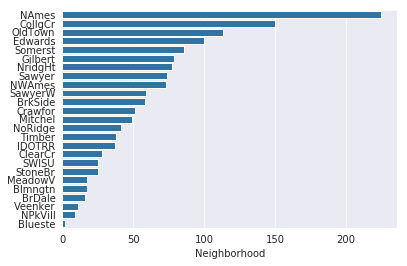

In [6]:
counts = train_data['Neighborhood'].value_counts(normalize=False, dropna=False)
horizontal_barplot(counts)

In [7]:
# there are too many levels of this cateogry with few data points
# so I'll just bin the least common levels into an "other" category
# NOTE: I arbitrarily picked the cutoff
cutoff = 40
low_cardinality_levels = counts[counts < cutoff].index
train_data.loc[train_data['Neighborhood'].isin(low_cardinality_levels), 'Neighborhood'] = 'other'

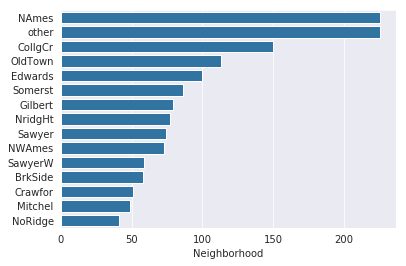

In [8]:
# this is the new distribution of the "clipped" neighborhood variable
horizontal_barplot(train_data['Neighborhood'].value_counts(normalize=False, dropna=False))

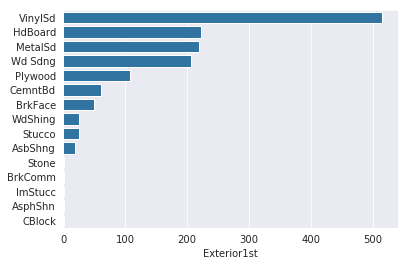

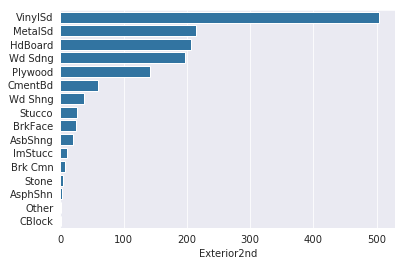

In [9]:
ext1_counts = train_data['Exterior1st'].value_counts(normalize=False, dropna=False)
ext2_counts = train_data['Exterior2nd'].value_counts(normalize=False, dropna=False)
horizontal_barplot(ext1_counts)
plt.show()
horizontal_barplot(ext2_counts)

### The "exterior" features
These appear to describe building materials, and it seems they share the same levels across both features. There are also some very low-cardinality levels. I'm actually going to convert both of these categories into a 2-hot encoded vector, which is a bit fancy compared to the standard approach.

In [10]:
# fix the difference between "CemntBd" and "CmentBd" for exterior type
train_data['Exterior1st'].replace('CemntBd', 'CmentBd', inplace=True)

In [11]:
# note: we use the same arbitrary cutoff from above
top_exteriors1 = ext1_counts[ext1_counts > cutoff]
top_exteriors2 = ext2_counts[ext2_counts > cutoff]
top_exteriors = list(set(top_exteriors1.index) | set(top_exteriors2.index))
top_exteriors

['CemntBd',
 'Plywood',
 'CmentBd',
 'VinylSd',
 'BrkFace',
 'MetalSd',
 'HdBoard',
 'Wd Sdng']

In [12]:
for exterior in top_exteriors:
    var_name = 'exterior_' + exterior
    for df in (train_data, test_data):
        df[var_name] = df['Exterior1st'].eq(exterior) | df['Exterior2nd'].eq(exterior)
        
for df in (train_data, test_data):
    df.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)

In [13]:
# here is a sample of the resulting features showing that sometimes two can be true at the same time
# (4th row), but that oftentimes only one of these top materials is present
train_data[[col for col in train_data if 'exterior' in col.lower()]].sample(5, random_state=1)

,exterior_CemntBd,exterior_Plywood,exterior_CmentBd,exterior_VinylSd,exterior_BrkFace,exterior_MetalSd,exterior_HdBoard,exterior_Wd Sdng
Id,,,,,,,,
259,False,False,False,True,False,False,False,False
268,False,False,False,False,False,False,False,True
289,False,False,False,False,False,True,False,False
650,False,False,True,False,False,False,False,False
1234,False,True,False,False,False,False,False,False


### The "condition" features
From a bit of poking around, it seems the "Condition1" and "Condition2" features are like the exterior features, but condition 2 is overwhelmingly "normal" suggesting that having a non-normal condition 2 may mean something else than a non-normal condition 1, so I won't two-hot encode them. The basement finish features are a little more complex, too, since there is both a square footage and a finish type associated with them, so I'll skip over those as well.

### Pandas categorical magic!

In [14]:
# okay, now we'll go ahead and make all of our categories categorical
# in pandas
cat_feats = train_data.select_dtypes('O').columns
for feature in cat_feats:
    train_data[feature] = train_data[feature].astype('category')
    # NOTE: we cast the test set to the EXACT SAME datatype, ensuring
    # the same levels of the categories across train and test
    # if we didn't do this, pandas might infer a different set of unique
    # values from the test set
    test_data[feature] = test_data[feature].astype(train_data[feature].dtype)

In [15]:
# let's revisit our datatypes now
count_dtypes(train_data)

category    41
int64       34
bool         8
float64      3
dtype: int64

# 3. Thinking about missing values
After I get the data properly typed, I want to then check to see if there might be any problems with missing values.

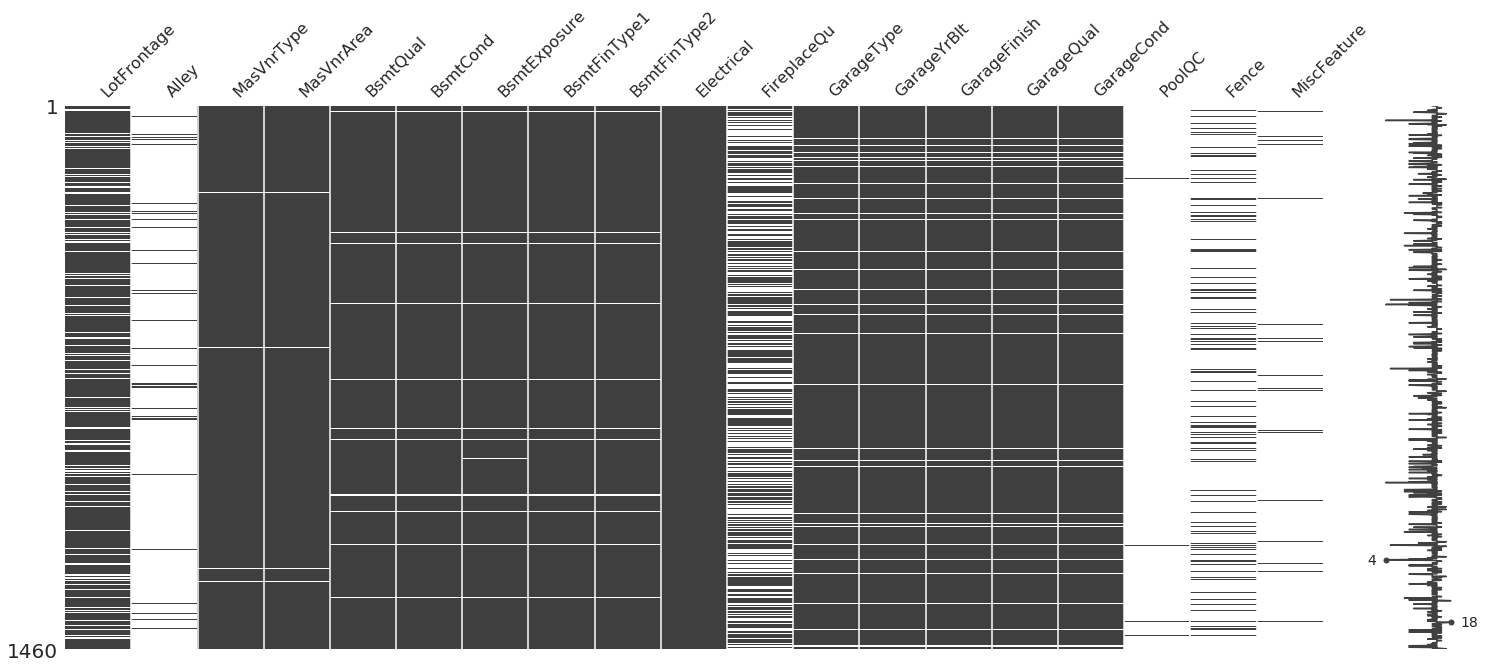

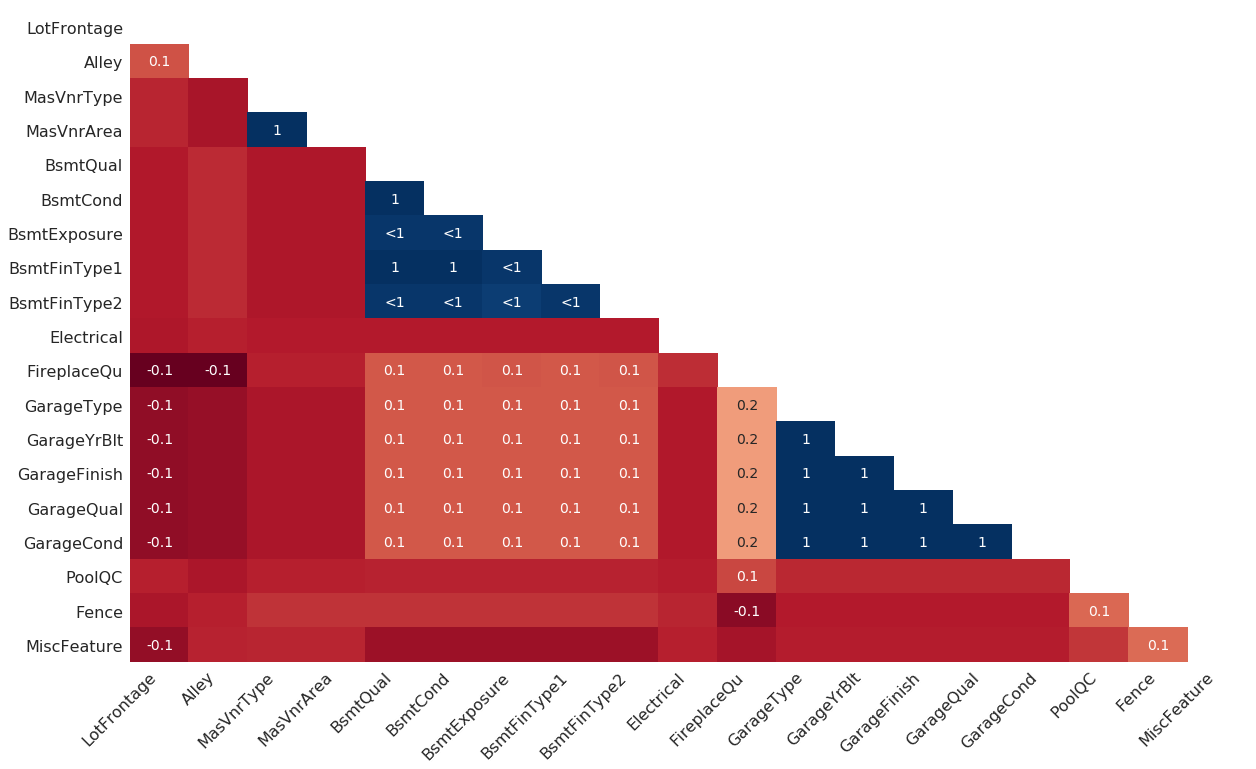

In [16]:
cols_with_missing = train_data.columns[train_data.isna().any(axis=0)]

# here are some handy plots for missing values
# the first shows the entire dataset as a color-coded matrix,
# where gray means the value is not missing, white means its missing
missingno.matrix(train_data[cols_with_missing])

# the second shows the correlation between missing values
# (there is often a lot of this in real datasets)
missingno.heatmap(train_data[cols_with_missing])

Text(0.5, 1.0, 'fraction of values missing by column')

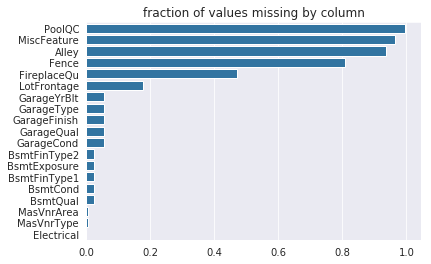

In [17]:
# we can also see how many values are missing
horizontal_barplot(train_data[cols_with_missing].isna().mean().sort_values(ascending=False))
plt.title('fraction of values missing by column')

### Missing conclusions
It seems like there might be some redundancy in missingness in the data, and since PoolQC and MiscFeature are missing so many values their individual levels will likely mean less than the fact that they have a value. However, I don't immediately see anything of value I can do in encoding them, so I'll just leave things as-is. Depending on the model we use, we will have to revisit encoding missing data meaningfully for that model on a model-specific basis, and knowing that some features are overwhelmingly missing will be helpful if we consider imputation.

# 4. Preparing the data for ML
Thanks to the proper categorical encoding above, we don't have to do any hacky df.align work, nor do we need to drop high-cardinality categorical features. We can instead do a very simple and straightforward rearrangement of the data.

In [18]:
# Drop houses where the target is missing
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

# pull all data data into target (y) and predictors (X)
# we log-transform the target, since the error metric for this
# competition is the RMSE between the log prediction and the log
# target, so we'll model the log target and then exponentiate it
# before submitting
train_target = train_data.pop('SalePrice').apply(np.log)

**Run outlier detection on Overall Quality of 10**

From the chart above we can clearly see that there are a few outliers for quality 10 so we'll run the Local Outlier Factor to detect these outliers. (anything with a -1 is an outlier)

In [19]:
# detect and drop outliers
outlier_detect = (pd.concat([train_data, train_target], axis=1)
                  .loc[train_data['OverallQual'] == 10, ['SalePrice', 'GrLivArea']])
outlier_detect['outlier'] = LocalOutlierFactor(n_neighbors=20).fit_predict(outlier_detect)
print(outlier_detect)
outliers = outlier_detect.loc[outlier_detect['outlier']==-1].index.values
train_data.drop(outliers, inplace=True)
train_target.drop(outliers, inplace=True)

      SalePrice  GrLivArea  outlier
Id                                 
59    12.991753       2945        1
186   13.071070       3608       -1
225   12.864240       2392        1
390   12.962195       2332        1
441   13.226723       2402        1
516   12.906347       2020        1
524   12.126759       4676        1
584   12.691580       2775        1
592   13.021327       2296        1
692   13.534473       4316        1
826   12.860999       2084        1
995   12.729321       1718        1
1170  13.345507       3627       -1
1183  13.521139       4476        1
1244  13.049793       2076        1
1299  11.982929       5642        1
1374  13.053013       2633        1
1443  12.644328       2007        1


# 5. Feature engineering

**Sum multiple features together to get overall totals**

In [20]:
def add_totals(df):
    # Add Total SF
    features_to_sum = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    df['newTotalSF'] = df[features_to_sum].sum(axis=1)

    # Add Total Finished SF
    features_to_sum = ['BsmtFinSF1','BsmtFinSF2','1stFlrSF','2ndFlrSF']
    df['newFinTotalSF'] = df[features_to_sum].sum(axis=1)

    # Add Total Bathrooms
    features_to_sum = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']
    df['newTotalBath'] = df[features_to_sum].sum(axis=1)

    # Add Total Porch SF
    features_to_sum = ['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']
    df['newTotalPorchSF'] = df[features_to_sum].sum(axis=1)

# 6. Modeling
Build best model and predict final results

In [21]:
# create a version of the DF with extra features
train_data_expanded = train_data.copy()
test_data_expanded = test_data.copy()
add_totals(train_data_expanded)
add_totals(test_data_expanded)

# order columns alphabetically by datatype to make it easier to look at
ordered_columns = (train_data
                   .dtypes
                   .apply(lambda x: x.name)
                   .reset_index()
                   .sort_values(by=[0, 'index'])
                   .loc[:, 'index']
                   .tolist())
train_data = train_data[ordered_columns]
train_data_expanded = train_data_expanded[ordered_columns]
test_data = test_data[ordered_columns]
test_data_expanded = test_data_expanded[ordered_columns]

# one-hot encode categorical variables
one_hot = category_encoders.OneHotEncoder(
    cols=train_data.select_dtypes('category').columns.tolist(),
    handle_unknown='ignore'
)
one_hot.fit(train_data)

train_input = one_hot.transform(train_data)
test_input = one_hot.transform(test_data)

train_input_expanded = one_hot.transform(train_data_expanded)
test_input_expanded = one_hot.transform(test_data_expanded)

# replace missing values with -999 (a good trick for boosted tree models)
train_input.fillna(-999, inplace=True)
test_input.fillna(-999, inplace=True)

In [22]:
# define the model
model_params = dict(
    n_estimators=20,
    learning_rate=0.25,
    subsample_freq=1,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=0,
)
model = lgb.LGBMRegressor(**model_params)

In [23]:
def rmse_score(model, X, y):
    """Scoring function: root mean squared error over 20-fold cross-validation"""
    return np.sqrt(-sklearn.model_selection.cross_val_score(
        model, X, y, 
        scoring="neg_mean_squared_error",
        cv=sklearn.model_selection.KFold(20, shuffle=True, random_state=0)))

In [24]:
# find an initial learning rate
lr_grid = [0.1, 0.2, 0.3, 0.4]
for lr in lr_grid:
    model.set_params(learning_rate=lr)
    print(f'Score at LR = {lr}: {rmse_score(model, train_input, train_target).mean():.4f}')

Score at LR = 0.1: 0.1520
Score at LR = 0.2: 0.1338
Score at LR = 0.3: 0.1360
Score at LR = 0.4: 0.1421


In [25]:
# narrow the search
lr_grid = [0.15, 0.18, 0.21, 0.24, 0.27]
for lr in lr_grid:
    model.set_params(learning_rate=lr)
    print(f'Score at LR = {lr}: {rmse_score(model, train_input, train_target).mean():.4f}')

Score at LR = 0.15: 0.1365
Score at LR = 0.18: 0.1346
Score at LR = 0.21: 0.1360
Score at LR = 0.24: 0.1346
Score at LR = 0.27: 0.1342


In [26]:
%%time
model.set_params(learning_rate=0.2)
# score our model (it seems the extra features don't do much, but they don't hurt)
for x in (train_input, train_input_expanded):
    rmses = rmse_score(model, x, train_target)
    print(f'Root Mean Squared Error: {rmses.mean():.4f} +/- {rmses.std():.4f} (1 standard deviation)')

Root Mean Squared Error: 0.1338 +/- 0.0264 (1 standard deviation)
Root Mean Squared Error: 0.1331 +/- 0.0255 (1 standard deviation)
CPU times: user 20.3 s, sys: 300 ms, total: 20.6 s
Wall time: 10.8 s


In [27]:
# tune the model: it doesn't seem max leaves restriction does much
for leaves in (10, 20, 30, 31, 40, 50, 100):
    model.set_params(num_leaves=leaves)
    print(f'Score at leaves = {leaves}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

# we might already be overfit with 31 leaves...
model.set_params(num_leaves=40)

Score at leaves = 10: 0.1370
Score at leaves = 20: 0.1342
Score at leaves = 30: 0.1343
Score at leaves = 31: 0.1331
Score at leaves = 40: 0.1341
Score at leaves = 50: 0.1347
Score at leaves = 100: 0.1347


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       importance_type='split', learning_rate=0.2, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=40, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=1)

In [28]:
for s in (0.5, 0.75, 0.9):
    model.set_params(subsample=s)
    print(f'Score at subsample = {s}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

Score at subsample = 0.5: 0.1354
Score at subsample = 0.75: 0.1340
Score at subsample = 0.9: 0.1329


In [29]:
model.set_params(subsample=0.75)
for c in (0.5, 0.75, 0.9, 1):
    model.set_params(colsample_bytree=c)
    print(f'Score at column subsample = {c}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

Score at column subsample = 0.5: 0.1340
Score at column subsample = 0.75: 0.1334
Score at column subsample = 0.9: 0.1340
Score at column subsample = 1: 0.1356


In [30]:
model.set_params(colsample_bytree=0.75)
for c in (1, 5, 10, 20, 40, 80):
    model.set_params(min_child_samples=c)
    print(f'Score at min child = {c}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

Score at min child = 1: 0.1348
Score at min child = 5: 0.1357
Score at min child = 10: 0.1344
Score at min child = 20: 0.1334
Score at min child = 40: 0.1372
Score at min child = 80: 0.1441


In [31]:
# okay, now use a large ensemble and tune learning rate for new number of trees
model.set_params(min_child_samples=20, n_estimators=1000)
for lr in tqdm.tqdm((0.005, 0.02, 0.08)):
    model.set_params(learning_rate=lr)
    print(f'Score at lr = {lr}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

 33%|███▎      | 1/3 [00:58<01:57, 58.96s/it]

Score at lr = 0.005: 0.1252


 67%|██████▋   | 2/3 [02:17<01:04, 64.86s/it]

Score at lr = 0.02: 0.1251


100%|██████████| 3/3 [03:38<00:00, 69.55s/it]

Score at lr = 0.08: 0.1283


In [32]:
# fine tune lr
for lr in tqdm.tqdm((0.01, 0.03, 0.05)):
    model.set_params(learning_rate=lr)
    print(f'Score at lr = {lr}: {rmse_score(model, train_input_expanded, train_target).mean():.4f}')

 33%|███▎      | 1/3 [01:07<02:15, 67.58s/it]

Score at lr = 0.01: 0.1235


 67%|██████▋   | 2/3 [02:26<01:10, 70.88s/it]

Score at lr = 0.03: 0.1250


100%|██████████| 3/3 [03:39<00:00, 71.73s/it]

Score at lr = 0.05: 0.1261


# 5. Submit results

In [33]:
# train on full dataset and submit results
model.set_params(learning_rate=0.01)
model.fit(train_input, train_target)
final_predicted_prices = np.exp(model.predict(test_input))
my_submission = pd.DataFrame({'SalePrice': final_predicted_prices}, index=test_data.index)
my_submission.to_csv('submission.csv', index=True)